In [15]:
from __future__ import print_function
import cv2
import numpy as np
import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal
import random
%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Double thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [3]:
def convolution2d(image, kernel, bias):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return new_image

In [4]:
def gaussian_smoothing(img):
    
    G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;
    
    img_out= convolution2d(img,G,0)
    
    return(img_out)

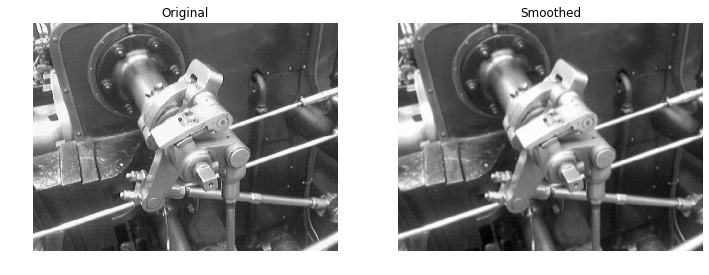

In [5]:
original   = cv2.imread('valve.png')
original   = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

smoothed=gaussian_smoothing(original)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(smoothed, cmap='gray')
plt.axis('off')
plt.title('Smoothed')

plt.show()

In [6]:
def gradient(img):
    
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    g_x=convolution2d(img,kernel_x,0)
    g_y=convolution2d(img,kernel_y,0)
    

    # Compute magnitude and direction
    magnitude = np.sqrt(g_x**2 + g_y**2)
    direction = np.arctan2(g_y, g_x)
    
    return magnitude, direction

In [7]:
def non_maximum_suppression(g_magnitude, g_dir):
    
    g_magnitude_max = np.zeros(g_magnitude.shape)
    
    # A padding to avoid issues with borders when moving around the picture
    g_magnitude_pad = np.pad(g_magnitude, 1, mode='constant')
    
    
    directions = [0, np.pi/4, np.pi/2, np.pi*3/4, np.pi, np.pi*(-3/4), np.pi*(-1/2), np.pi*(-1/4), -np.pi]
    
    height, width = g_dir.shape

    
    #Searching the nearest direction among the list above
    for x in range(height):
        for y in range(width):
            
            min_dist=np.pi/4
            
            for direction in directions:
                dist_direct=np.abs(direction-g_dir[x, y])
                if dist_direct<min_dist:
                    min_direct=dist_direct
                    best_dir= direction
            
            
            delta_x = 0
            delta_y = 0
            move=1
            if best_dir in [0,np.pi,-np.pi]:
                delta_x=0
                delta_y=1
                move=1
            elif best_dir in [np.pi/4, np.pi*(-3/4), np.pi/2, np.pi*(-1/2)]:
                delta_x=1
                delta_y=1
                move=1
            else:
                delta_x=1
                delta_y=1
                move=-1
                
            if g_magnitude[x, y] >= max(g_magnitude_pad[x+1+delta_x, y+1+delta_y*move],g_magnitude_pad[x+1-delta_x, y+1-delta_y*move]):
                g_magnitude_max[x, y] = g_magnitude[x, y]
    
    return g_magnitude_max     
                
            

In [8]:
def double_thresholding(g_max,thresh_lo=0.1, thresh_hi=0.2):
    #if greater than hi assign "definite, if between high and low assign weak, assign null otherwise"
    threshold = np.where(g_max > thresh_hi, 'definite', np.where(g_max > thresh_lo, 'weak', 'null'))
    return threshold

In [9]:
def connectivity(thresh_img):
    
    edge = np.zeros(thresh_img.shape)
    edge_pad = np.pad(edge, 1, mode='constant')
    height, width = thresh_img.shape
    
    for x in range(height):
        for y in range(width):
            if thresh_img[x, y] == 'definite':
                edge[x, y] = 1
            elif thresh_img[x, y] == 'weak':
                neighbours=[]
                moves=[[-1,0],[1,0],[-1,1],[1,1],[-1,-1],[1,-1],[0,1],[0,-1]]
                
                # If weak, search for a definite neighbour
                for move in moves:
                    neighbours.append(edge_pad[x+1+move[0], y+1+move[1]])
                if 'definite' in neighbours:
                    edge[x, y] = 1
    return edge
                        

In [10]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    print("smoothing")
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    print("gradients")
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    print("non max suppression")
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    print("double thresholding")
    # Double thresholding
    thresh_img           = double_thresholding(g_max,thresh_lo=0.1, thresh_hi=0.2)
    
    print("connectivity")
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

smoothing
gradients
non max suppression
double thresholding
connectivity


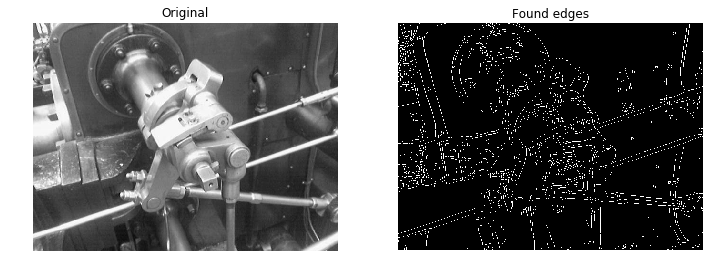

In [11]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255

edges = canny_edge_detector(img)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

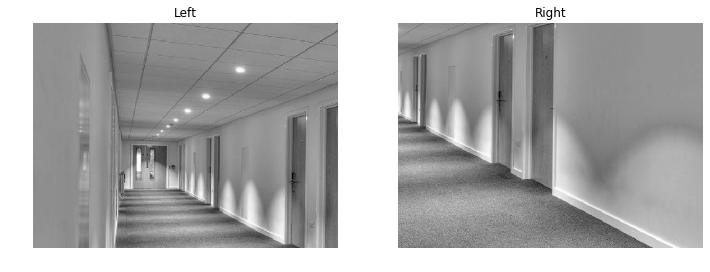

In [12]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

In [13]:
def harris_corner_detector(img, thresh = 10e14, mask_size = 6, k = 0.04, kernel_size = 5, border = None):
    """
    Performs Harris corner detection on an image
    Parameters:
        ## INPUT
        - img (np.ndarray): Image on which we wish to detect corners
        
        ## HARRIS
        - thresh (float): On sait pas trop ce qu'est ce sale FDP
        - k (float): Harris corner constant. Usually 0.04 - 0.06
        - mask_size (int): Mask size of the detector
        
        ## SOBEL
        - kernel_size (int): Size of the sobel kernel
        - border (None or cv2.BORDER_***): border for the Sobel filter
    Output:
    - List of corners (x, y, r)
    """
    # SOBEL OPERATOR
    
    ## Adjusting the border for the Sobel kernel
    if border is not None: border = cv2.borderInterpolate(0, 1, border)
    else: border = cv2.BORDER_DEFAULT

    ## Compute gradients with border
    ix = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize=kernel_size, borderType=border)
    iy = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize=kernel_size, borderType=border)
    ixx = ix**2
    ixy = ix*iy
    iyy = iy**2
    
    # HARRIS CORNER DETECTOR
    
    ## Useful variables
    corners = np.zeros((img.shape))
    offset = int(mask_size/2)
    
    ## Iterate over values
    for x in range(offset, img.shape[0]-offset):
        for y in range(offset, img.shape[1]-offset):

            # Calculate sum of squares
            Sxx = ixx[x-offset:x+offset+1, y-offset:y+offset+1].sum()
            Sxy = ixy[x-offset:x+offset+1, y-offset:y+offset+1].sum()
            Syy = iyy[x-offset:x+offset+1, y-offset:y+offset+1].sum()

            # Find determinant and trace
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            # If corner response is over threshold, add it to the corner list
            if r > thresh: corners[x, y] = r
                
    return corners

Text(0.5, 1.0, 'Left')

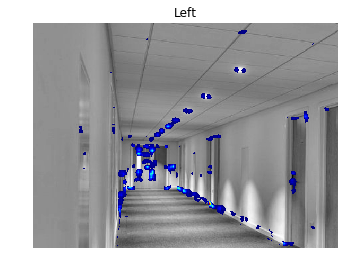

In [17]:
# Harris corner
corners = harris_corner_detector(left_img, thresh = 0.5*10e9, mask_size = 6, k = 0.05, kernel_size = 3, border = None)

# Plot to verify results and experiment
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.imshow(np.ma.masked_where(corners == 0, corners), cmap=cm.jet, interpolation='none')
#plt.plot(x_coord, y_coord, "o")
plt.axis('off')
plt.title('Left')

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [19]:
def find_random_pair(corners_left, corners_right):
    """
    Find a random pair of corners (c_left, c_right) from the corners of the image.
    Parameters:
    - corners_left (): Corner matrix of left image (from harris_detector)
    - corners_right (): Corner matrix of right image (from harris_detector)
    Output:
    - c_left, c_right: Randomly selected 2D corners (one for each image)
    """
    # Retrive non-zero indices
    idxs_right = np.argwhere(corners_right != 0)
    idxs_left = np.argwhere(corners_left != 0)    
    
    # Creating random indices
    x = np.random.choice(len(idxs_right), size = 1)
    y = np.random.choice(len(idxs_left), size = 1)

    return(idxs_left[y].flatten(), idxs_right[x].flatten())

def find_translation_vector(c_left, c_right):
    """
    Compute the translation vector from left to right.
    Parameters:
    - c_left: Left corner (from find_random_pair)
    - c_right: Right corner (from find_random_pair)
    """
    x = c_left[1] - c_right[1]
    y = c_left[0] - c_right[0]
    return(np.array([x, y]))

def compute_error(translation_vector, left_img, right_img):
    """
    For two images left_img and right, and a pair or corners (c_left, c_right), this function computes the
    error between the intersection of the images when the corners are aligned.
    """
    # USEFUL QUANTITIES
    
    ## Image dimensions
    height, width = left_img.shape

    ## Maximum possible error
    max_error = 255 * width * height
    
    ## Translation coordinates
    x_trans, y_trans = translation_vector[0], translation_vector[1]
    
    # CASE BY CASE SOLUTION
    if x_trans <= 0 or y_trans <= 0:
        """
        Case 0: This corresponds to the case is in the wrong direction for our two images.
        """
        return(max_error, np.zeros((1, 1)), np.zeros((1, 1)))
    
    else:
        """
        Case 1: The right image is below the left one
        """
        cropped_left=left_img[y_trans:,x_trans:]
        cropped_right=right_img[:height-y_trans, :width-x_trans]
    
    # Compute error
    error = np.abs(cropped_left - cropped_right).mean()
    
    return(error, cropped_left, cropped_right)

def stitch(left_img, right_img, translation_vector):
    """
    Stitch two images based on a translation vector
    Parameters:
    - left (np.ndarray): Right image
    - right (np.ndarray): Right image
    - translation_vector (np.ndarray): 2D translation vector (from find_translation_vector)
    Output:
    - result_img (np.ndarray): Stitched image of left_img and right_img
    """
    # Useful variables
    height, width = left_img.shape
    x_trans, y_trans = translation_vector[0], translation_vector[1]
    
    # Initialize stitched image
    result_img = np.zeros((int(1.6*height), int(1.6*width)))
    
    
    # Add left and right image to the resulting image
    result_img[0:height, 0:width] = left_img
    result_img[y_trans : height + y_trans, x_trans : width + x_trans] = right_img
    
    # Plot
    plt.figure(figsize=(15,9))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title('Stitched images')
    return(result_img)

In [20]:
# Left right bitch
corners_left  = harris_corner_detector(left_img, 10e10, mask_size = 6)
corners_right = harris_corner_detector(right_img, 10e10, mask_size = 6)

In [23]:
def stitch_images_full(left, right, max_tries = 50000, plot_progress = True):
    """
    
    """
    # Initialize some variables
    best_error = 255*left.shape[0]*left.shape[1]
    best_translation = None

    # Iteration
    for n_try in range(max_tries):

        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)

        # Get translation vector
        translation_vector = find_translation_vector(c_left, c_right)

        # Compute resulting error. 
        this_error, cropped_left, cropped_right = compute_error(translation_vector, left_img, right_img)

        # Cheating a bit
        cropped_dim_condition = cropped_left.shape[0] > 200 and cropped_left.shape[1] > 200

        if this_error < best_error and cropped_dim_condition:

            # Update error and translation_vector
            best_error   = this_error
            best_translation   = translation_vector

            # Verbose
            if plot_progress:
                print('Iteration : ' + str(n_try))
                print('- Error : ' + str(best_error))
                print('- Translation vector :' + str(best_translation))

                plt.figure(figsize=(12,6))

                plt.subplot(2, 2, 1)
                plt.imshow(left_img, cmap='gray')
                plt.plot(c_left[1], c_left[0], "o")
                plt.axis('off')
                plt.title('Left image with corners')

                plt.subplot(2, 2, 2)
                plt.imshow(right_img, cmap='gray')
                plt.plot(c_right[1], c_right[0], "o")
                plt.axis('off')
                plt.title('Right image with corners')

                plt.subplot(2, 2, 3)
                plt.imshow(cropped_left, cmap='gray')
                plt.axis('off')
                plt.title('Cropped left image')

                plt.subplot(2, 2, 4)
                plt.imshow(cropped_right, cmap='gray')
                plt.axis('off')
                plt.title('Cropped right image')

                plt.show()

    result_img = stitch(left_img, right_img, best_translation)
                
    return(result_img)

Iteration : 0
- Error : 132.14823633156968
- Translation vector :[330 101]


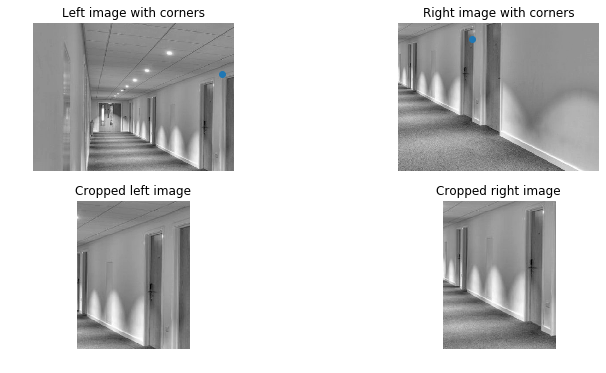

Iteration : 6
- Error : 129.97199917003837
- Translation vector :[197 170]


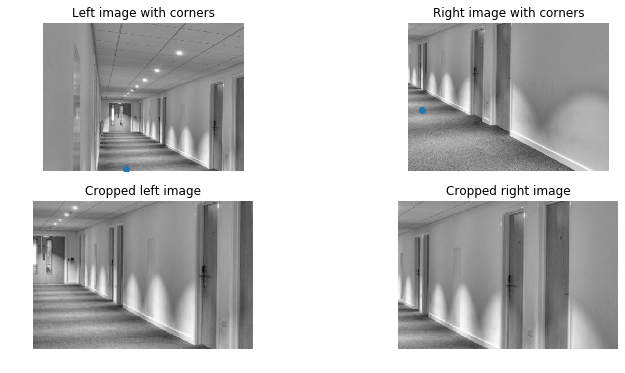

Iteration : 84
- Error : 129.14549629475002
- Translation vector :[240 139]


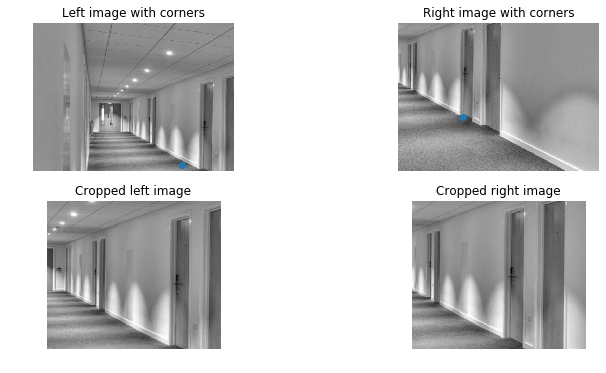

Iteration : 148
- Error : 127.12495655196385
- Translation vector :[176 151]


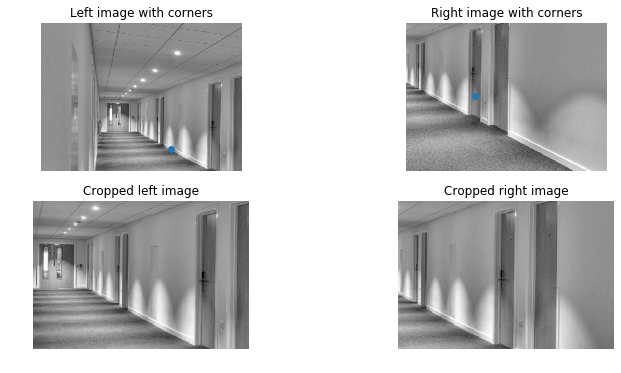

Iteration : 233
- Error : 124.26262510254307
- Translation vector :[310 195]


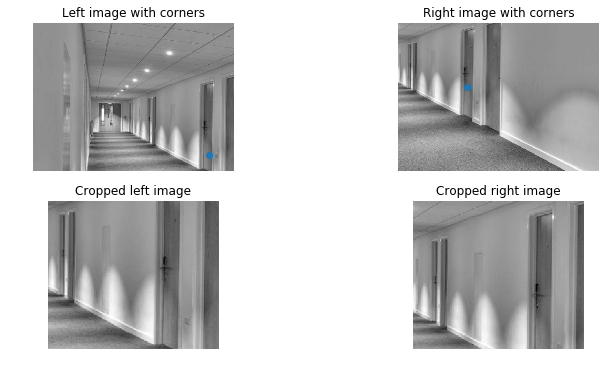

Iteration : 276
- Error : 123.40913370041517
- Translation vector :[ 22 158]


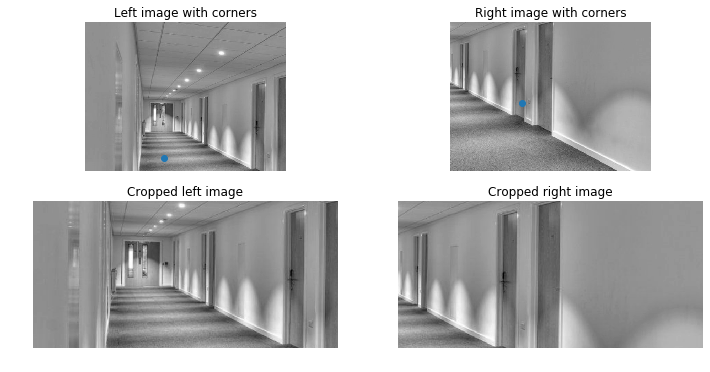

Iteration : 373
- Error : 120.95163214614016
- Translation vector :[368 178]


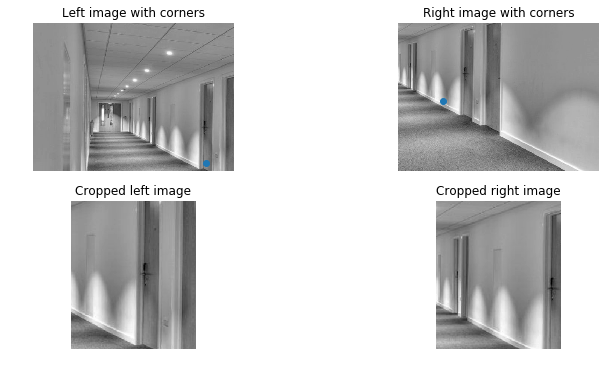

Iteration : 404
- Error : 117.06845388188454
- Translation vector :[301 150]


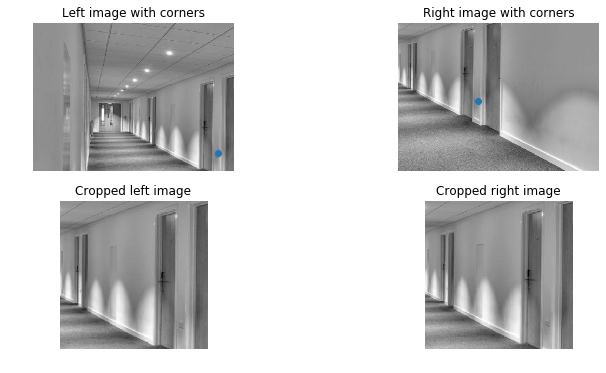

Iteration : 769
- Error : 116.39336138382421
- Translation vector :[296 195]


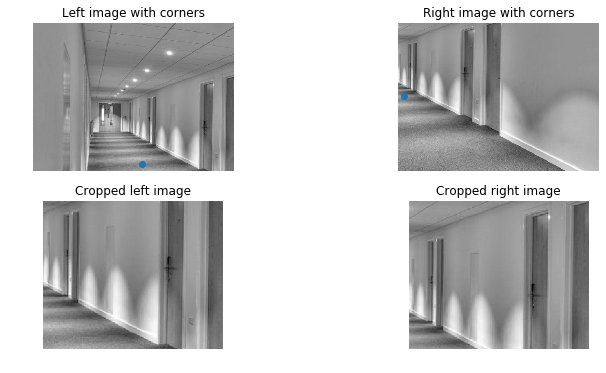

Iteration : 2994
- Error : 112.42422907488987
- Translation vector :[365 198]


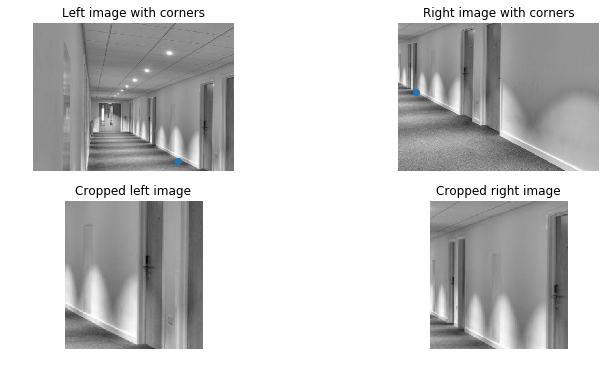

Iteration : 11332
- Error : 109.59222051251702
- Translation vector :[298 181]


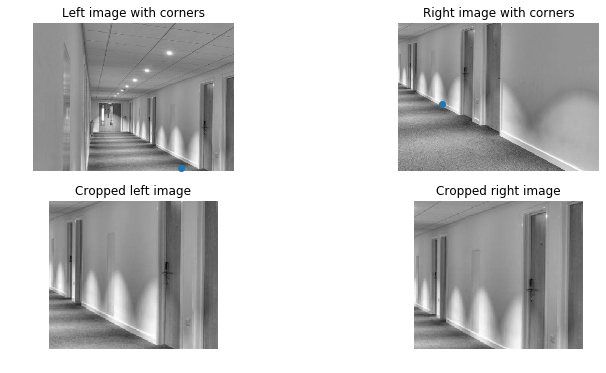

Iteration : 23483
- Error : 100.74935341343823
- Translation vector :[298 157]


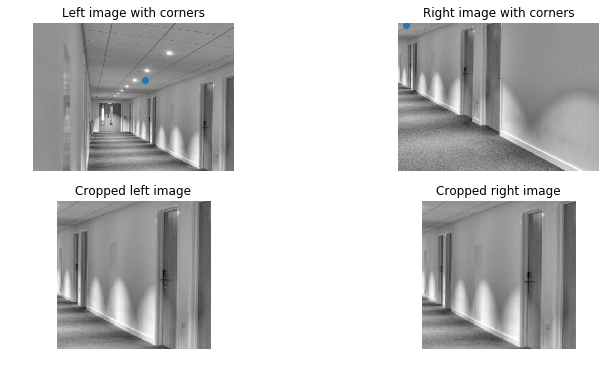

Iteration : 35225
- Error : 91.5605743424584
- Translation vector :[299 155]


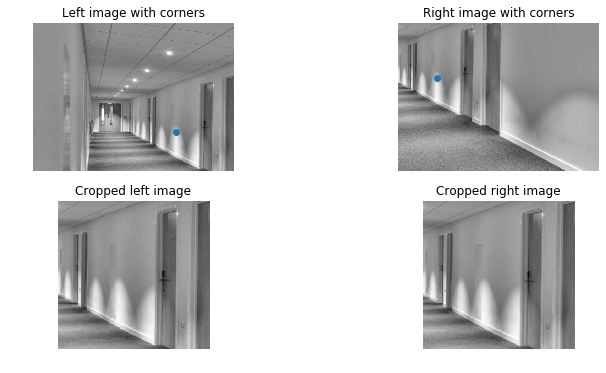

array([[149., 149., 149., ...,   0.,   0.,   0.],
       [149., 149., 149., ...,   0.,   0.,   0.],
       [149., 149., 149., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

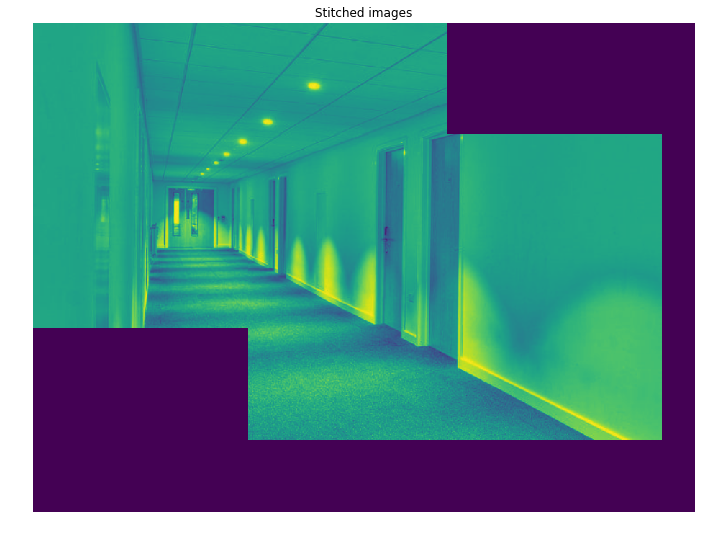

In [24]:
stitch_images_full(left_img, right_img, max_tries = 50000, plot_progress = True)